In [1]:
# Date -- 2022.Aug.28
# Using Python 3.9
'''
pip install --upgrade pip
pip install scipy
pip install jupyter matplotlib h5py
pip install emcee corner tqdm
pip install pandas
'''

'\npip install --upgrade pip\npip install scipy\npip install jupyter matplotlib h5py\npip install emcee corner tqdm\npip install pandas\n'

In [2]:
import os, sys, time

sys.path

import numpy as np

import matplotlib
# matplotlib.use('PDF')
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

import emcee, corner
from multiprocessing import Pool
from multiprocessing import cpu_count

import pandas as pd
%matplotlib inline

from profilefit import *

#### Data explanation

In the data files, from first to last column: 

  0) index
  
  1) position angle (degree)
  
  2) intensity in Jy/beam, 


# Define model function

In [3]:
def gaussian_1d(x, parms):
    '''
    Return a Gaussian distribution that is normalized to 1.0
             
    Input:
        x [1d np array] : offset
        parms [list of float] : [amp, x0, sigma]
            amp [float]     : amplitude
            x0 [float]      : central position of the Gaussian
            sigma [float]   : standard deviation of the Gaussian
            
    Return:
        [1d np array]   : A 1-dim Gaussian function that has the same size as the x array.
    '''
    amp   = parms[0]
    x0    = parms[1]
    sigma = parms[2]
    
    num_x = len(x)
    A = 1.0 / (sigma * np.sqrt(2.0 * np.pi))
    B     = np.zeros(num_x)
    
    for i in range(0, num_x):
        x1 = np.abs( x[i] - x0 )
        x2 = np.abs( x[i] - (x0+360.0) )
        xdiff = np.min( [x1,x2] )
        
        B[i] = -0.5 * (( xdiff/sigma )**2.0)

    return amp * A * np.exp(B)


    
def gaussian_1d_lnprior(parms):
    '''
    Prior function.
    '''
    
    return 0


def twogaussian_1d(x, parms):
    '''
    Return a Gaussian distribution that is normalized to 1.0
             
    Input:
        x [1d np array] : offset
        parms [list of float] : [amp, x0, sigma]
            dcoffset [float]  : a DC offset
            amp_1 [float]     : amplitude
            x0_1 [float]      : central position of the Gaussian
            sigma_1 [float]   : standard deviation of the Gaussian
            
            amp_2 [float]     : amplitude
            x0_2 [float]      : central position of the Gaussian
            sigma_2 [float]   : standard deviation of the Gaussian            
            
    Return:
        [1d np array]   : A 1-dim Gaussian function that has the same size as the x array.
    '''
    amp   = parms[1]
    x0    = parms[2]
    sigma = parms[3]
    
    in_parms = [amp,x0,sigma]
    y1 = gaussian_1d(x, in_parms)

    amp   = parms[4]
    x0    = parms[5]
    sigma = parms[6]
    
    in_parms = [amp,x0,sigma]
    y2 = gaussian_1d(x, in_parms)

    return y1 + y2 + parms[0]


    
def twogaussian_1d_lnprior(parms):
    '''
    Prior function.
    '''
    if parms[0]<0:
        return -np.inf    
    if parms[1]<0:
        return -np.inf        
    if parms[2]<0:
        return -np.inf
    if parms[3]<0:
        return -np.inf     
    if parms[5]<0:
        return -np.inf 
    
    return 0


NEED TO PROPERLY EDIT THESE PARAMETERS!!!
######## Processing ../../cuts_profiles/DMTau_X_intensity_3sigmacut.txt##########
Loading file : ../../cuts_profiles/DMTau_X_intensity_3sigmacut.txt
You have 80 CPUs


/data2/supervision/students/Master/Yuka_Terada/MCMC/shared_mcmc_Terada/analysis/Tb_profile/profilefit.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.DataFrame.offset[elements] = 1e-15


########### Starting running MCMC ########### Sun Sep 18 23:28:10 2022


  0%|                                                                          | 0/100 [00:00<?, ?it/s]/home/hyliu/softwares/python/Anaconda/envs/profilefit2022/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.35it/s]


########### Finished running MCMC ########### Sun Sep 18 23:28:29 2022
parameter 0: 1.5e-05+2e-06-3.9e-07
parameter 1: 0.00038+0.00022-8.6e-05
parameter 2: 1.3e+02+1.9e+02-6.5
parameter 3: 37+4.8-11
parameter 4: 0.0002+9.7e-05-4e-05
parameter 5: 2.3e+02+1.1e+02-1e+02
parameter 6: 30+7.1-10


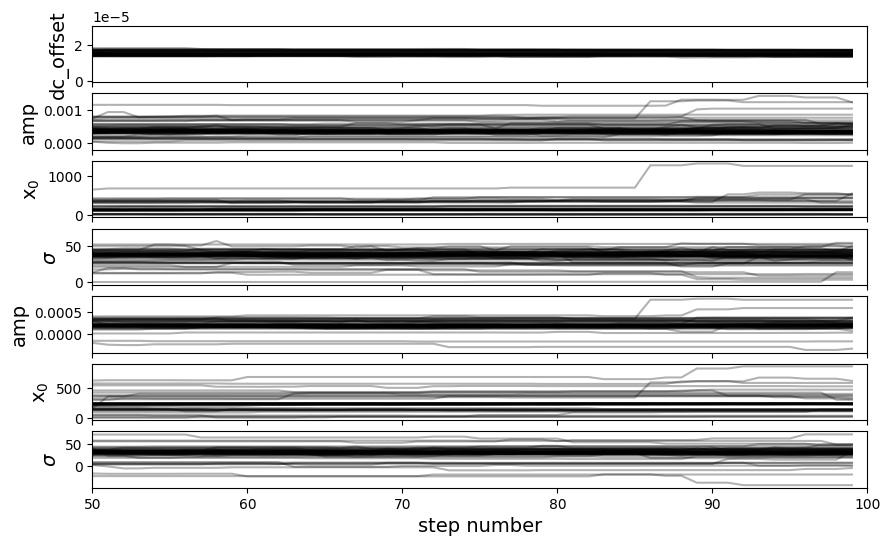

<Figure size 640x480 with 0 Axes>

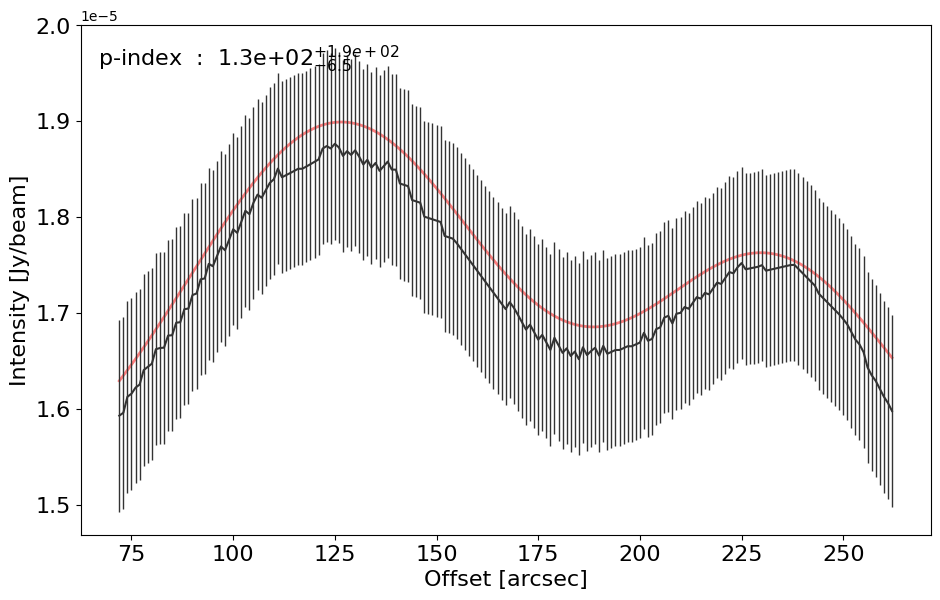

Start making corner plotSun Sep 18 23:28:30 2022
Finished making corner plotSun Sep 18 23:28:36 2022


<Figure size 640x480 with 0 Axes>

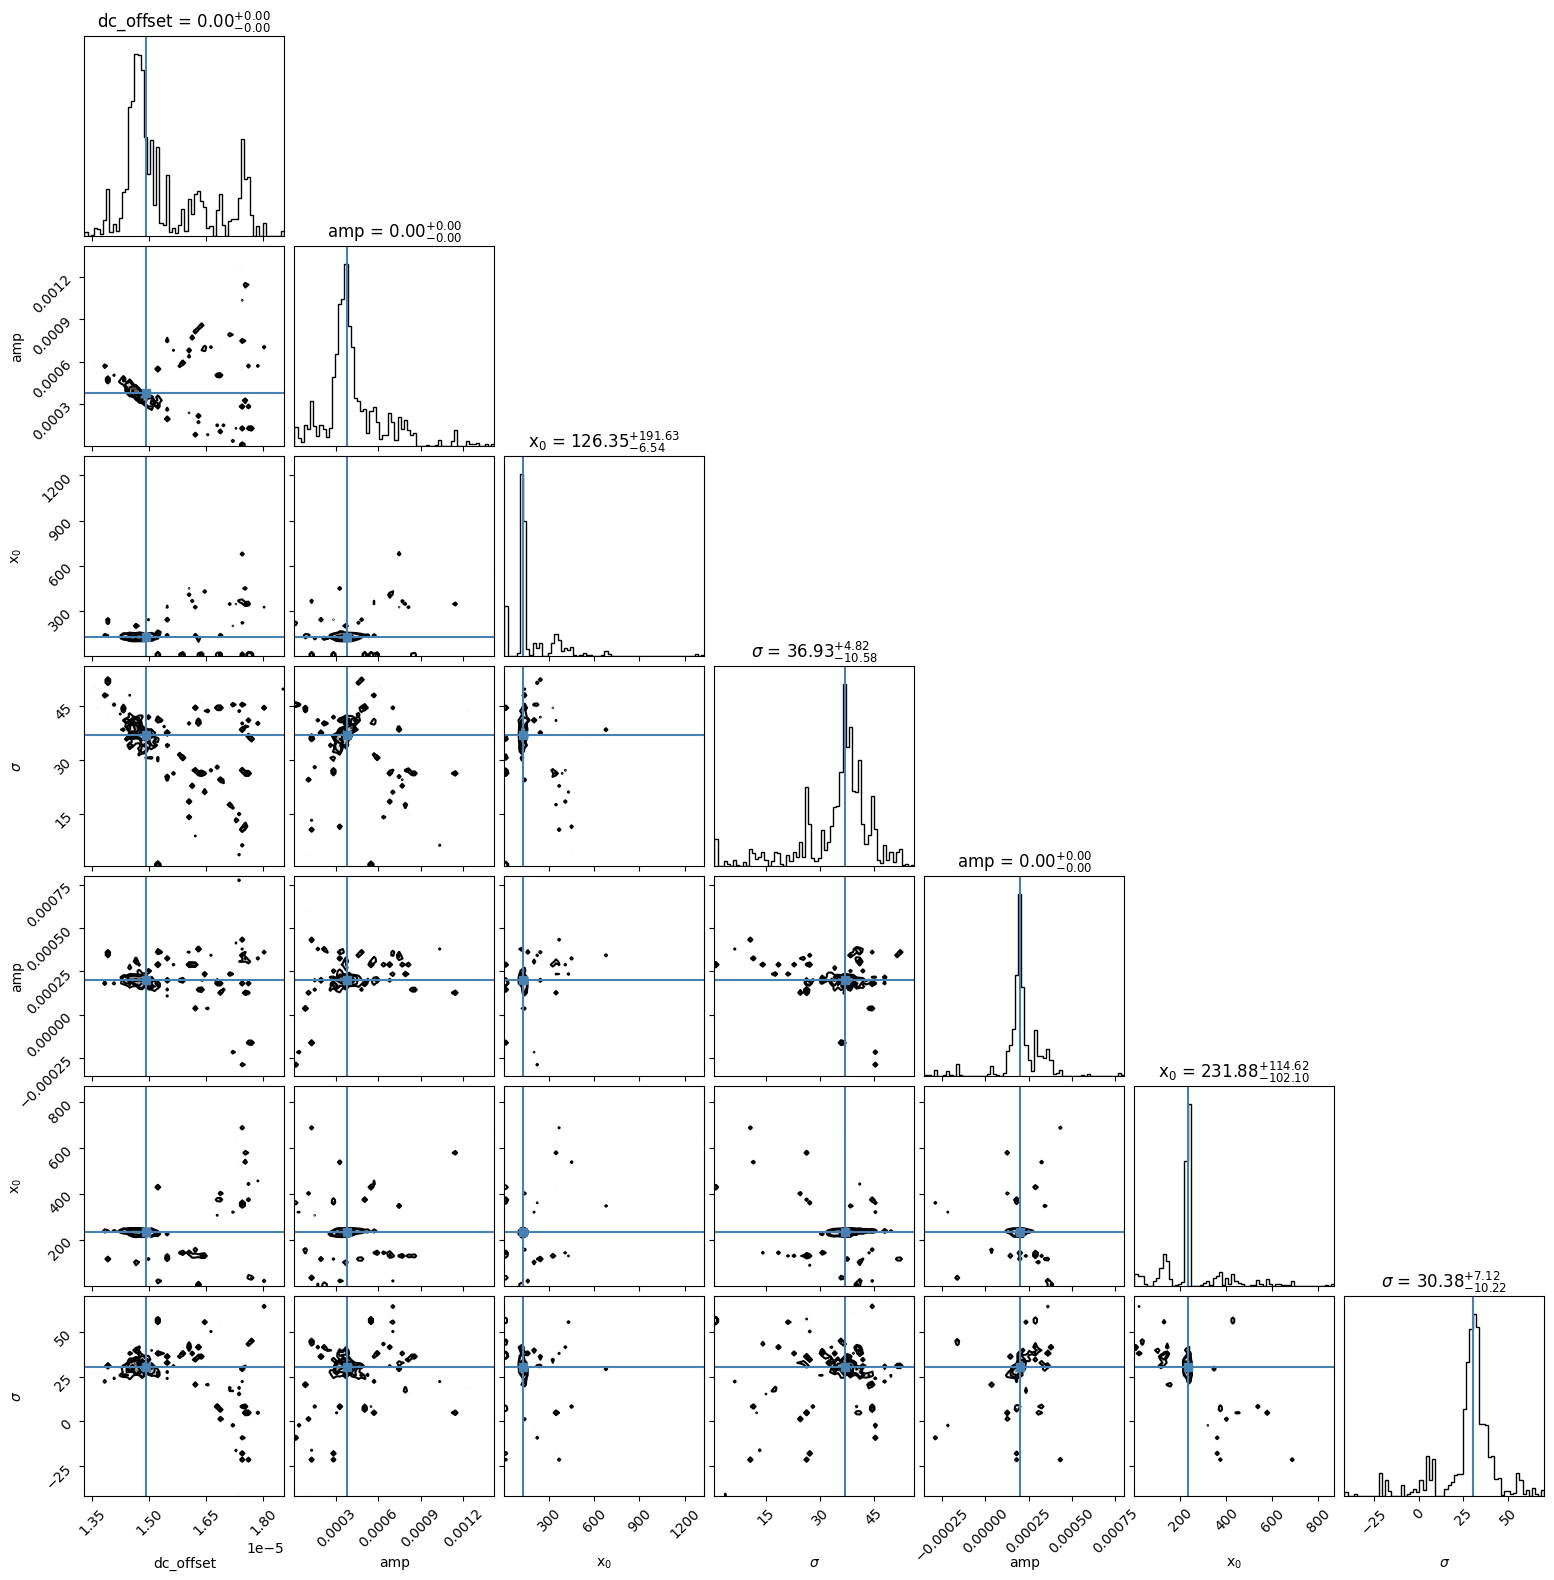

In [4]:
# Data setup
path     = '../../cuts_profiles/'
filename = 'DMTau_X_intensity_3sigmacut.txt'
bmaj, bmin, bpa, freqGHz = 0.04063, 0.03567, 0.0, 225.0
print('NEED TO PROPERLY EDIT THESE PARAMETERS!!!')

# model setup
init_parms   = [1.4e-5, 5e-4, 120.0, 30.0, 2e-4, 220.0, 30.0]
model_func   = twogaussian_1d
lnprior_func = twogaussian_1d_lnprior
parms_range = []

# MCMC setup
nwalkers        = 60   # need to be a few times larger than the number of free-parameters
nsteps          = 100
n_processor     = 60
step_to_discard = 50

# output setup
emcee_backend_name = 'twogaussian.h5'
samplerFig_name    = 'twogaussian.pdf'
profileFig_name    = 'twogaussian.pdf'
cornerFig_name     = 'twogaussian.pdf'
labels             = ['dc_offset', 'amp','x$_{0}$','$\sigma$', 'amp','x$_{0}$','$\sigma$']

# Flow Control
if_rerun         = False
if_plotSampler   = True
if_outputSamples = False
if_MakeCorner    = True


##### Fitting process #######################################################################################
print('######## Processing ' + path + filename + '##########')

test = profilefit()

# Obtain the angular resolution in the direction of the slice
test.load_profile(filename = path + filename,
                  bmaj=bmaj, bmin=bmin, bpa=bpa, freqGHz=freqGHz,
                  # xrange = [75, 175]
                 )


# initialize MCMC fittings
test.initialize_mcmc(
                     model_func, lnprior_func, 
                     nwalkers     = nwalkers, 
                     init_parms   = init_parms,  # initial model parameters
                     backend_name = emcee_backend_name,
                     parms_range  = parms_range,
                     rerun = if_rerun
                    )


##### Initialize MCMC #######################################################################################
ncpu = cpu_count()
print("You have {0} CPUs".format(ncpu))

if (n_processor < ncpu):
    # Setup multi-processor
    pool = Pool(processes = n_processor)
        
    # Construct emcee sampler
    sampler = emcee.EnsembleSampler(
                                    test.nwalkers,     # number of walkers
                                    len( test.parms ), # number of free-parameters
                                    test.lnprob,       # function to evaluate log probability
                                    args    = test.args,
                                    backend = test.backend,
                                    # pool = pool      # Multi-processor (does not work for Macbook Pro)
                                   )

if (n_processor < ncpu):
    
##### Runnning MCMC ########################################################################################
    print (  '########### Starting running MCMC ###########', time.asctime( time.localtime(time.time()) ) )
    sampler.run_mcmc( test.initial_pos, nsteps, progress=True)
    print (  '########### Finished running MCMC ###########',  time.asctime( time.localtime(time.time()) ) )
   
    
##### Summarize the results ################################################################################
if (n_processor < ncpu):

    test.summarize_mcmc(sampler, step_to_discard=step_to_discard)
    
    for i in range(0, len(test.parms)):
        s_string = 'parameter ' + str(i) + ': '
        s_string += str( format(test.parms[i], '.2g')      )  + r'+'
        s_string += str(  format(test.parms_u[i] - test.parms[i], '.2g')  )  + r'-'
        s_string += str(  format(test.parms[i] - test.parms_l[i], '.2g')  )
        print(s_string)
    
    # Plot the variation of sampler values as steps
    if if_plotSampler == True:
        test.plot_sampler(sampler, 
                          outfigname = samplerFig_name,
                          labels = labels,
                          # plot_range = parms_range
                         )    
    
    # Plot the data and the fitted profile
    label_string = 'p-index  :  ' + str( format(test.parms[2], '.2g')    )  + r'$' \
                              + r'^{+' + str(  format(test.parms_u[2] - test.parms[2], '.2g')  ) + r'}' \
                              + r'_{-' + str(  format(test.parms[2] - test.parms_l[2], '.2g')  ) + r'}' \
                              + r'$'    
    test.plot_profile(
                  # xscale='log', yscale='log',
                  outfigname = profileFig_name,
                  label = label_string, label_fontsize=16, 
                  x_label='Offset [arcsec]', y_label='Intensity [Jy/beam]',
                  x_label_fontsize=16, y_label_fontsize=16,
                  tick_fontsize=16,
                 )

    
    # Output all samplers to a ASCII file
    if if_outputSamples == True:
        test.output_samples()
    
    
    # Making corner plot (extremely time consuming)
    if if_MakeCorner == True:
        test.make_corner(
                         outfigname = cornerFig_name,
                         plot_contours = True,
                         labels = labels,
                         # plot_range = parms_range
                        )
    

In [ ]:
a